In [1]:
import networkx as nx
import itertools
import datapackage
import pandas as pd
from typing import List
import matplotlib.pyplot as plt


## Yakoob's Code ##

In [2]:
# import csv file of routes data
df = pd.read_csv('routes.txt')

# delete columns that contain additional information about airlines
df = df.drop(['Airline', 'Airline ID', 'Codeshare', 'Stops', 'Equipment'], axis=1) 

# Create directed graph from routes data
G = nx.DiGraph()
for index, row in df.iterrows(): G.add_edge(row['Source ID'], row['Destination ID'])
    

# Read airport data to map Airport ID -> Country
df2 = pd.read_csv('airports.txt')
df2 = df2.drop(['Latitude','Longitude','Altitude','Timezone','DST',
                'database time zone','Type','Source','City','Name'], axis=1) 



In [3]:
# Get the country name from ID number
country = dict()

for index, row in df2.iterrows(): 
    country[row['Airport ID']] = row['Country']

# helper function to retrieve country name given an airport ID
def get_country(ID):
    # @return country_name - str
    
    if ID == "\\N" or float(ID) not in country:
        return 'No ID'
    
    return country[float(ID)]

In [4]:
# International graph network, weighted by number of routes between two countries
country_graph = nx.DiGraph()
max_weight = 0
for index, row in df.iterrows(): 
    source, destination = get_country(row['Source ID']), get_country(row['Destination ID'])
    if source != 'No ID' and destination != 'No ID':
        if country_graph.has_edge(source, destination):
            country_graph[source][destination]['weight'] += 1
        else:
            country_graph.add_edge(source, destination, weight=1) 
            
        max_weight = max(max_weight, country_graph[source][destination]['weight'])

## Sucharita's Code ##

In [5]:
def normalize_weights(G, max_weight):
    N = list(G.nodes())
    E = [(u,v,max(0, data['weight']/max_weight - 0.0000000001)) for (u,v,data) in G.edges(data=True)]
    
    G1 = nx.DiGraph()
    G1.add_nodes_from(N)
    G1.add_weighted_edges_from(E)
    
    return G1

In [ ]:
nodes: list = [
    ("USA", SIRD(b=1/2, k=1/3, w=1/4, N=1500000, i=0.2), (0.5, 0.5)),
    ("Canada", SIRD(b=1/2, k=1/3, w=1/4, N=1000000, i=0.5), (0.45, 0.4)),
    ("Mexico", SIRD(b=1/2, k=1/3, w=1/4, N=2000000, i=0.99), (0.6, 0.6)),
]

edges: list = [
    ("USA", "Canada", 0.1),
    ("USA", "Mexico", 0.2)
]

In [6]:
def duplicate_verts(graph, pop_dict, granularity, self_weights, weights):
    # new dict with num of duplicated vertices per location
    num_vert_dict = {k: int(v / granularity) for (k, v) in pop_dict.items()}
    nodes = list(graph)
    
    new_nodes = []
    missed = [] #Locations we don't have populations for
    NDict = {}
    next_node = 1
    for loc in nodes:
        nbs = [n for n in graph.neighbors(loc)]
        if loc not in pop_dict:
            missed += [loc]
            NDict[loc] = [next_node]
            next_node+=1
        else:
            nodes = [next_node+i for i in range(max(1, num_vert_dict[loc]))] #Countries with pop<granularity should still have a node
            next_node += max(1, num_vert_dict[loc])
            new_nodes += nodes
            NDict[loc] = nodes      
    
    if len(missed):
        print("Missing population for the following locations: ")
        print(missed)

    new_edges = get_new_edges(NDict, list(graph.edges(data=True)), self_weights, weights)

    G = nx.DiGraph()
    G.add_nodes_from(new_nodes)
    G.add_weighted_edges_from(new_edges)
    return G, NDict
    

In [7]:
def get_new_edges(NDict, edges, self_weights, weights):
    E = []
    missed = set()
    missed_self = set()
    for (v1, v2, w) in edges:
        if v1 in weights and v2 in weights:
            weight = get_edge_weight(w['weight'], weights[v1], weights[v2])
            E += list(itertools.product(NDict[v1],NDict[v2], [weight]))
        else:
            if v1 not in weights:
                missed.add(v1)
            if v2 not in weights:
                missed.add(v2)
    for n in NDict:
        if n not in self_weights:
            missed_self.add(n)
        else:
            E += list(itertools.product(NDict[n], NDict[n], [self_weights[n]]))
            
    if len(missed):
        print("Missing weights for the following locations: ")
        print(missed)  
    if len(missed_self):
        print("Missing self_weights for the following locations: ")
        print(missed_self) 
        
    return E 
    

In [8]:
# Calculates what the weight should be on edge (n1,n2) n1!=n2
# Will get more complicated eventually

def get_edge_weight(base_weight, w_n1, w_n2):
    return base_weight

In [9]:
# Population Related Functions

def get_pop_data():
    data_url = 'https://datahub.io/JohnSnowLabs/population-figures-by-country/datapackage.json'

    # to load Data Package into storage
    package = datapackage.Package(data_url)

    # to load only tabular data
    resources = package.resources
    for resource in resources:
        if resource.tabular:
            data = pd.read_csv(resource.descriptor['path'])
    return data

def pop_dict_year(data, year):
    label = 'Year_' + str(year)
    df = data[['Country',label]]
    pop_dict = {}
    for i in range(df.shape[0]):
        pop_dict[df.iloc[i][0]] = df.iloc[i][1]

    return pop_dict

In [10]:
# Josiah's Code:

def draw_weighted_edges(G: nx.Graph, pos: List[tuple], bins: int = 10):
    """
    Plots the network with weighted edges
    """
    edgelists: list = [[] for i in range(bins)]
    for u, v, eprops in G.edges(data=True):
        edgelists[int(bins * eprops['weight'])].append((u, v))

    for i, edges in enumerate(edgelists):
        nx.draw_networkx_edges(G, pos, edgelist=edges,
            width=i * 0.3 + 0.1, alpha=0.6 + i/40)

In [11]:
# Visualization Code

def invert_nDict(NDict):
    D = {}
    for k in NDict:
        for v in NDict[k]:
            D[v] = k
    return D

def visualize_duplicated_graph(G, NDict):
    inv_dict = invert_nDict(NDict)
    print("finished inverting dict")
    G1 = nx.relabel_nodes(G, inv_dict)
    print("finished relabeling")
    draw_weighted_edges(G1, nx.spring_layout(G1))

Missing population for the following locations: 
['Russia', 'Egypt', 'Gambia', 'Hong Kong', 'Taiwan', 'Burma', 'Bahamas', 'Venezuela', 'Netherlands Antilles', 'Guadeloupe', 'French Guiana', 'Martinique', 'Saint Lucia', 'South Korea', 'Macedonia', 'Brunei', 'Macau', 'Saint Kitts and Nevis', 'Kyrgyzstan', 'Iran', 'Anguilla', 'Virgin Islands', 'Guernsey', 'Jersey', 'Congo (Kinshasa)', 'Laos', 'Congo (Brazzaville)', 'Mayotte', 'Reunion', 'Western Sahara', 'Cape Verde', 'North Korea', 'Slovakia', 'Yemen', 'Cook Islands', 'Falkland Islands', 'Saint Vincent and the Grenadines', 'East Timor', 'Norfolk Island', 'Niue', 'Saint Pierre and Miquelon', 'Wallis and Futuna', 'Micronesia', 'Cocos (Keeling) Islands', 'Christmas Island']
Missing weights for the following locations: 
{'Cocos (Keeling) Islands', 'Cook Islands', 'Saint Kitts and Nevis', 'Congo (Brazzaville)', 'Guadeloupe', 'Micronesia', 'Yemen', 'Macau', 'Gambia', 'Christmas Island', 'Laos', 'Anguilla', 'Saint Lucia', 'Netherlands Antilles'

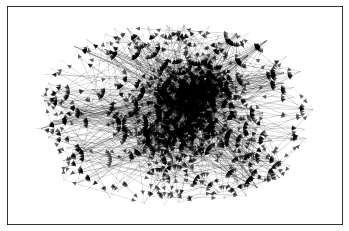

In [13]:
# Run Yakoob's Code

# pop_dict
G = normalize_weights(country_graph, max_weight)


pop_dict = pop_dict_year(get_pop_data(), 2003)
weights = {k:0 for k in pop_dict}
self_weights = {k:0 for k in pop_dict}#FIGURE THIS OUT
granularity = 10000000

G, NDict = duplicate_verts(G, pop_dict, granularity, self_weights, weights)
visualize_duplicated_graph(G, NDict)

## Random Testing Code (Scrap) ##

In [292]:
G=nx.DiGraph()
G.add_nodes_from(['a', 'b', 'c'])
G.add_weighted_edges_from([('a','b', 0.1), ('b', 'c', 0.6), ('c', 'a', 0.8), ('a','c', 0.9), ('a', 'c', 0.1)])
print([G.get_edge_data(u, v) for (u,v) in G.edges()])
weights = {'a': 0.1, 'b':0.5, 'c': 0.15}
self_weights = {'a': 0.1,'b': 0.2, 'c': 0.15}
pop_dict = {'a': 10000, 'b': 5000, 'c':15000}
granularity = 5000

G, NDict = duplicate_verts(G, pop_dict, granularity, self_weights, weights)
print(NDict)

[{'weight': 0.1}, {'weight': 0.1}, {'weight': 0.6}, {'weight': 0.8}]
{'a': [1, 2], 'b': [3], 'c': [4, 5, 6]}


[(1, 3, 0.1), (1, 4, 0.1), (1, 5, 0.1), (1, 6, 0.1), (1, 1, 0.1), (1, 2, 0.1), (2, 3, 0.1), (2, 4, 0.1), (2, 5, 0.1), (2, 6, 0.1), (2, 1, 0.1), (2, 2, 0.1), (3, 4, 0.6), (3, 5, 0.6), (3, 6, 0.6), (3, 3, 0.2), (4, 1, 0.8), (4, 2, 0.8), (4, 4, 0.15), (4, 5, 0.15), (4, 6, 0.15), (5, 1, 0.8), (5, 2, 0.8), (5, 4, 0.15), (5, 5, 0.15), (5, 6, 0.15), (6, 1, 0.8), (6, 2, 0.8), (6, 4, 0.15), (6, 5, 0.15), (6, 6, 0.15)]


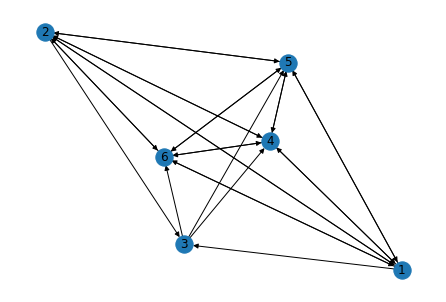

In [293]:
nx.draw(G, with_labels=True)
print([(u,v,G.get_edge_data(u, v)['weight']) for (u,v) in G.edges()])

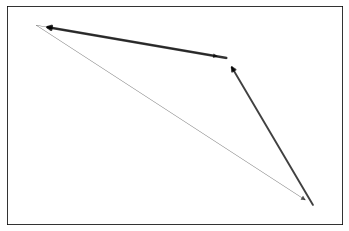

In [294]:
visualize_duplicated_graph(G, NDict)

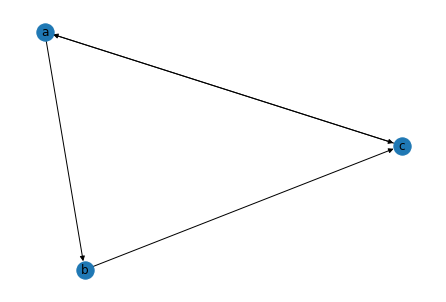

In [295]:
inv_dict = invert_nDict(NDict)
G1 = nx.relabel_nodes(G, inv_dict)
nx.draw(G1, with_labels=True)

In [226]:
data = get_pop_data()
print(data)
print(pop_dict_year(data, 1992))

          Country Country_Code   Year_1960   Year_1961   Year_1962  \
0           Aruba          ABW     54211.0     55438.0     56225.0   
1     Afghanistan          AFG   8996351.0   9166764.0   9345868.0   
2          Angola          AGO   5643182.0   5753024.0   5866061.0   
3         Albania          ALB   1608800.0   1659800.0   1711319.0   
4         Andorra          AND     13411.0     14375.0     15370.0   
..            ...          ...         ...         ...         ...   
258        Kosovo          XKX    947000.0    966000.0    994000.0   
259   Yemen, Rep.          YEM   5172135.0   5260501.0   5351799.0   
260  South Africa          ZAF  17396367.0  17850045.0  18322335.0   
261        Zambia          ZMB   3044846.0   3140264.0   3240587.0   
262      Zimbabwe          ZWE   3747369.0   3870756.0   3999419.0   

      Year_1963   Year_1964   Year_1965   Year_1966   Year_1967  ...  \
0       56695.0     57032.0     57360.0     57715.0     58055.0  ...   
1     9533954.0